In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

### Data load

In [2]:
df = pd.read_parquet("/home/asado/Descargas/Anyone AI/final_sprint/yellow_tripdata_2022-05.parquet") ##change the path for your own local
df.sample(10, random_state=42) #seed of randomness for reproducibility

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee
3043622,2,2022-05-27 16:45:16,2022-05-27 16:52:08,1.0,0.90,1.0,N,249,114,1,6.0,1.0,0.5,2.06,0.0,0.3,12.36,2.5,0.0
208456,1,2022-05-03 10:01:56,2022-05-03 10:19:06,1.0,0.80,1.0,N,141,141,2,6.5,2.5,0.5,0.00,0.0,0.3,9.80,2.5,0.0
942942,1,2022-05-09 16:59:46,2022-05-09 17:03:47,1.0,0.70,1.0,N,151,238,1,5.0,3.5,0.5,1.85,0.0,0.3,11.15,2.5,0.0
247636,2,2022-05-03 16:30:52,2022-05-03 16:41:19,1.0,1.72,1.0,N,87,148,1,8.5,1.0,0.5,2.56,0.0,0.3,15.36,2.5,0.0
3052006,2,2022-05-27 18:45:16,2022-05-27 18:53:46,1.0,1.54,1.0,N,42,24,1,8.0,1.0,0.5,1.96,0.0,0.3,11.76,0.0,0.0
1291561,2,2022-05-12 15:22:00,2022-05-12 15:29:22,5.0,1.03,1.0,N,107,234,1,6.5,0.0,0.5,1.00,0.0,0.3,10.80,2.5,0.0
3073378,2,2022-05-27 21:24:03,2022-05-27 21:32:10,4.0,1.19,1.0,N,161,48,1,7.0,0.5,0.5,2.16,0.0,0.3,12.96,2.5,0.0
3423926,2,2022-05-31 18:53:00,2022-05-31 19:03:35,1.0,1.78,1.0,N,163,234,1,9.0,1.0,0.5,2.66,0.0,0.3,15.96,2.5,0.0
3486168,2,2022-05-06 18:40:00,2022-05-06 18:44:00,NaN,0.83,NaN,None,87,45,0,10.0,0.0,0.5,2.00,0.0,0.3,15.30,NaN,NaN
778070,2,2022-05-07 22:12:17,2022-05-07 22:24:17,2.0,1.68,1.0,N,161,107,2,9.5,0.5,0.5,0.00,0.0,0.3,13.30,2.5,0.0


### Data descriptive analysis

In [3]:
print(f"This dataset is composed of {df.shape[0]} rows and {df.shape[1]} columns")

This dataset is composed of 3588295 rows and 19 columns


Since the dataset is very big and it's gonne consume a lot of hardware, we will work with a subsample.

In [4]:
df_subset = df.sample(10000, random_state=42) #seed of randomness for reproducibility

In [5]:
df_subset.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10000 entries, 3043622 to 1089672
Data columns (total 19 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   VendorID               10000 non-null  int64         
 1   tpep_pickup_datetime   10000 non-null  datetime64[ns]
 2   tpep_dropoff_datetime  10000 non-null  datetime64[ns]
 3   passenger_count        9633 non-null   float64       
 4   trip_distance          10000 non-null  float64       
 5   RatecodeID             9633 non-null   float64       
 6   store_and_fwd_flag     9633 non-null   object        
 7   PULocationID           10000 non-null  int64         
 8   DOLocationID           10000 non-null  int64         
 9   payment_type           10000 non-null  int64         
 10  fare_amount            10000 non-null  float64       
 11  extra                  10000 non-null  float64       
 12  mta_tax                10000 non-null  float64       
 13

### Check for unique values and na's

In [6]:
df_subset.isna().sum()/df_subset.shape[0]*100

VendorID                 0.00
tpep_pickup_datetime     0.00
tpep_dropoff_datetime    0.00
passenger_count          3.67
trip_distance            0.00
RatecodeID               3.67
store_and_fwd_flag       3.67
PULocationID             0.00
DOLocationID             0.00
payment_type             0.00
fare_amount              0.00
extra                    0.00
mta_tax                  0.00
tip_amount               0.00
tolls_amount             0.00
improvement_surcharge    0.00
total_amount             0.00
congestion_surcharge     3.67
airport_fee              3.67
dtype: float64

Very few null values, so they can be taken out of the dataset withoput losing much information.

In [7]:
df.nunique()/df.shape[0]*100

VendorID                  0.000111
tpep_pickup_datetime     48.900968
tpep_dropoff_datetime    48.849635
passenger_count           0.000279
trip_distance             0.132960
RatecodeID                0.000195
store_and_fwd_flag        0.000056
PULocationID              0.007218
DOLocationID              0.007274
payment_type              0.000139
fare_amount               0.226821
extra                     0.001700
mta_tax                   0.000362
tip_amount                0.105315
tolls_amount              0.021431
improvement_surcharge     0.000084
total_amount              0.400720
congestion_surcharge      0.000195
airport_fee               0.000084
dtype: float64

We can say that we dont have a lot of variability in the dataset, except for two variables that will be transformed in the next step.

### Creation of a "duration" variable

One of the aims of the projects it's to predict duration of the trips baes in all other variables, so we will form the duration variable calculating a diference between trip drop-off and pick up, as it follows:

In [8]:
df_subset["duration"] = df_subset["tpep_dropoff_datetime"].dt.hour - df_subset["tpep_pickup_datetime"].dt.hour
df_subset = df_subset.drop(["tpep_pickup_datetime", "tpep_dropoff_datetime"], axis=1)

In [9]:
round(df_subset.describe(),2)

,VendorID,passenger_count,trip_distance,RatecodeID,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee,duration
count,10000.00,9633.00,10000.00,9633.00,10000.00,10000.00,10000.00,10000.00,10000.00,10000.00,10000.00,10000.00,10000.00,10000.00,9633.00,9633.00,10000.00
mean,1.72,1.41,3.66,1.35,164.59,162.12,1.18,15.26,1.00,0.49,2.88,0.57,0.30,22.23,2.29,0.10,0.08
std,0.48,0.96,4.58,5.10,65.72,70.05,0.50,14.49,1.26,0.09,3.43,2.19,0.05,18.15,0.73,0.34,2.11
min,1.00,0.00,0.00,1.00,1.00,1.00,0.00,-65.50,-4.50,-0.50,-0.01,-13.75,-0.30,-68.55,-2.50,-1.25,-23.00
25%,1.00,1.00,1.15,1.00,132.00,113.00,1.00,7.00,0.00,0.50,1.00,0.00,0.30,12.36,2.50,0.00,0.00
50%,2.00,1.00,2.00,1.00,162.00,162.00,1.00,10.50,0.50,0.50,2.26,0.00,0.30,16.30,2.50,0.00,0.00
75%,2.00,2.00,3.73,1.00,234.00,234.00,1.00,17.00,2.50,0.50,3.50,0.00,0.30,23.76,2.50,0.00,1.00
max,6.00,6.00,59.48,99.00,265.00,265.00,4.00,300.00,8.25,0.50,104.00,86.00,0.30,314.05,2.50,1.25,3.00


### EDA graphical phase

Distribution of the variable VendorID


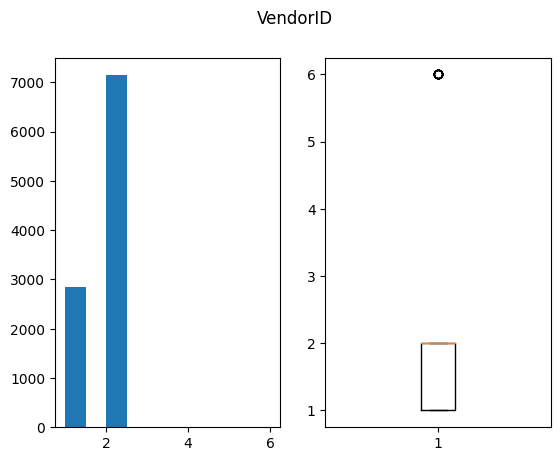

Mode= 2
Mean= 1.7209
Median= 2.0


Distribution of the variable passenger_count


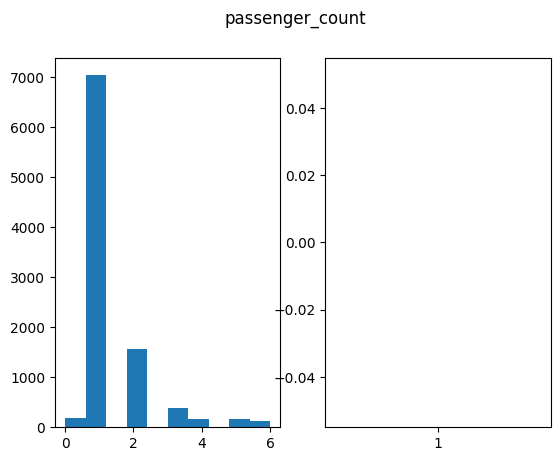

Mode= 1.0
Mean= 1.4101526004360012
Median= 1.0


Distribution of the variable trip_distance


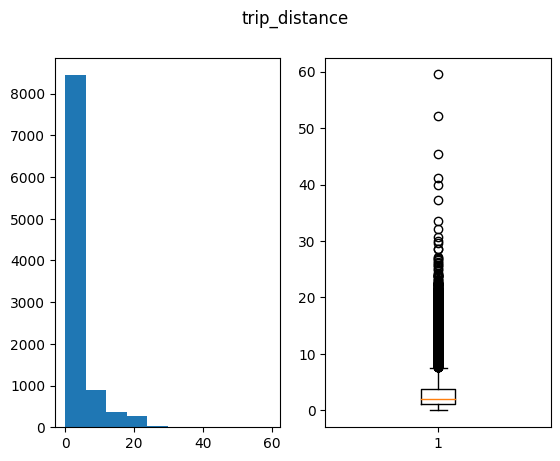

Mode= 0.0
Mean= 3.655668
Median= 2.0


Distribution of the variable RatecodeID


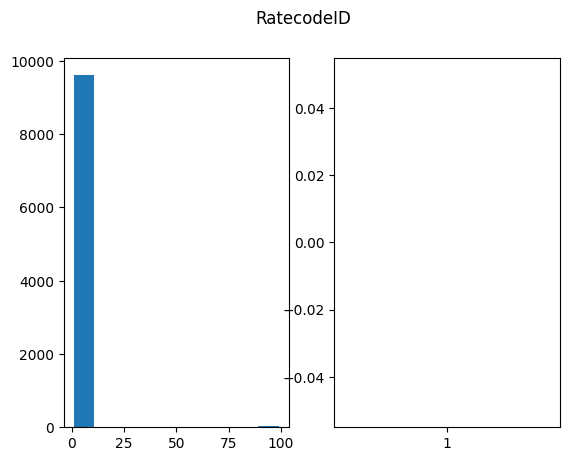

Mode= 1.0
Mean= 1.3535762483130904
Median= 1.0


Distribution of the variable PULocationID


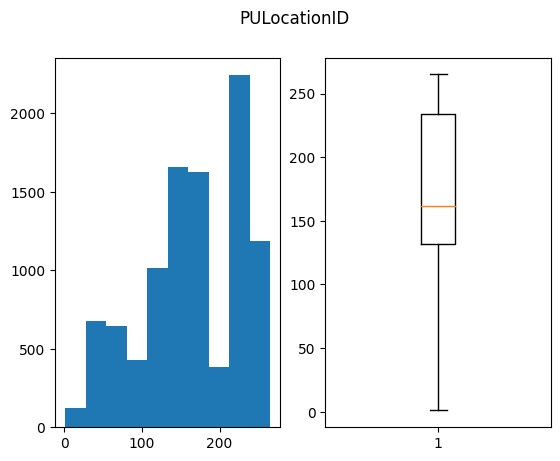

Mode= 132
Mean= 164.5924
Median= 162.0


Distribution of the variable DOLocationID


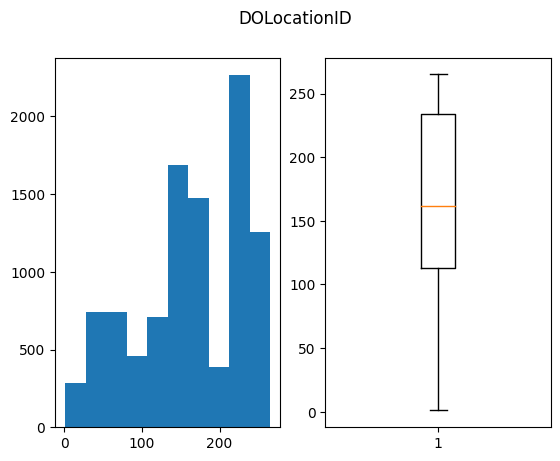

Mode= 236
Mean= 162.1153
Median= 162.0


Distribution of the variable payment_type


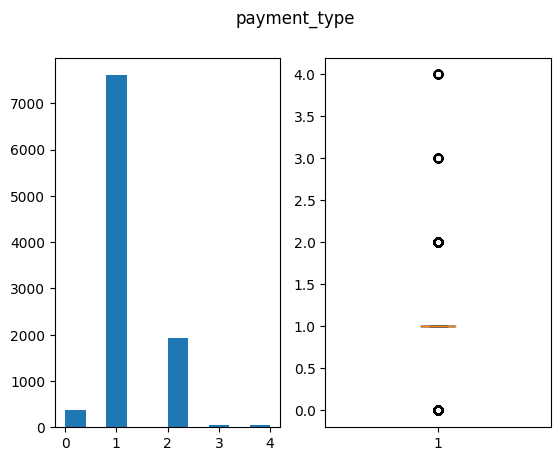

Mode= 1
Mean= 1.1789
Median= 1.0


Distribution of the variable fare_amount


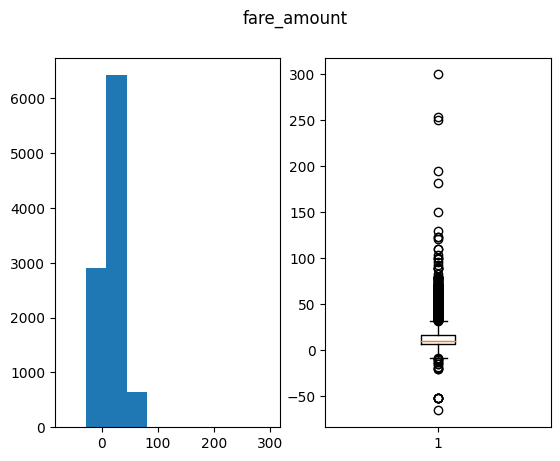

Mode= 7.0
Mean= 15.259331
Median= 10.5


Distribution of the variable extra


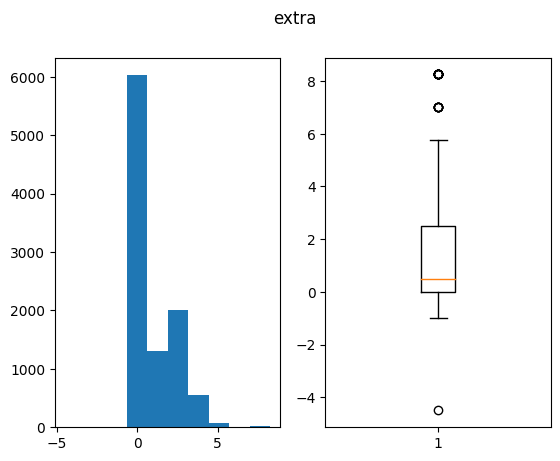

Mode= 0.0
Mean= 1.004225
Median= 0.5


Distribution of the variable mta_tax


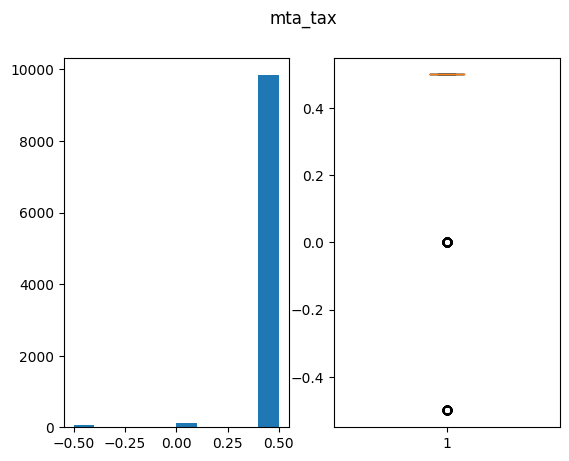

Mode= 0.5
Mean= 0.489
Median= 0.5


Distribution of the variable tip_amount


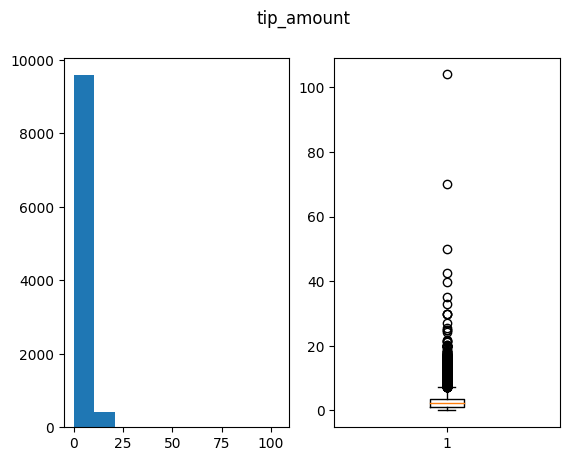

Mode= 0.0
Mean= 2.880286
Median= 2.26


Distribution of the variable tolls_amount


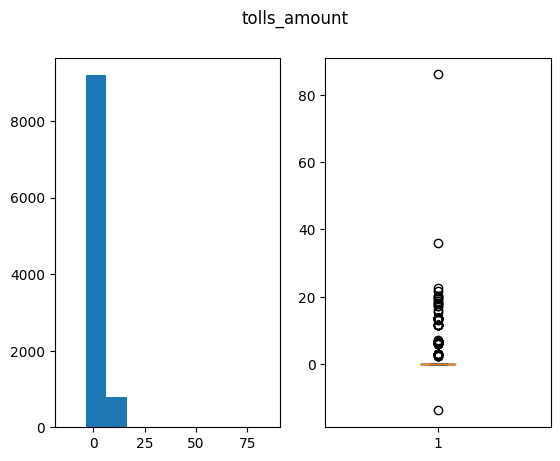

Mode= 0.0
Mean= 0.574491
Median= 0.0


Distribution of the variable improvement_surcharge


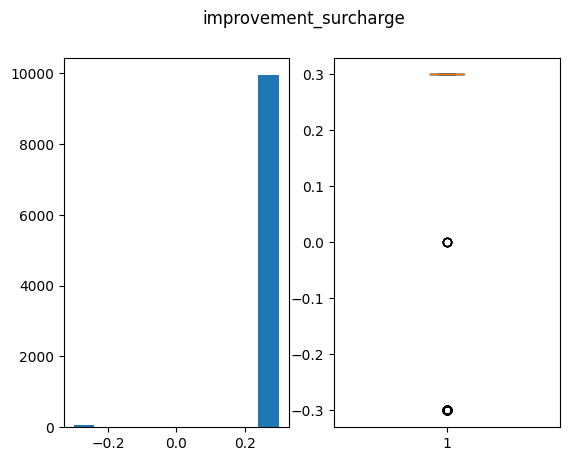

Mode= 0.3
Mean= 0.2964299999999999
Median= 0.3


Distribution of the variable total_amount


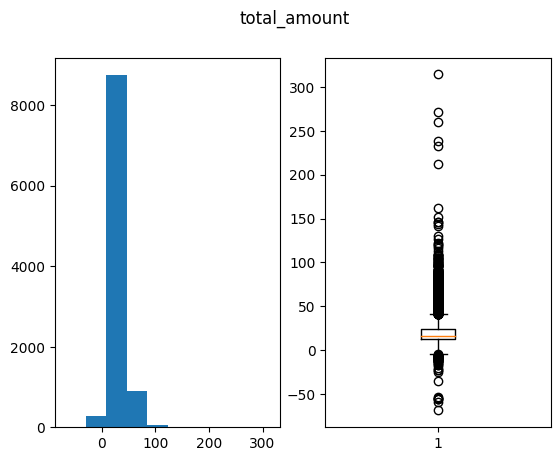

Mode= 13.56
Mean= 22.225913000000002
Median= 16.3


Distribution of the variable congestion_surcharge


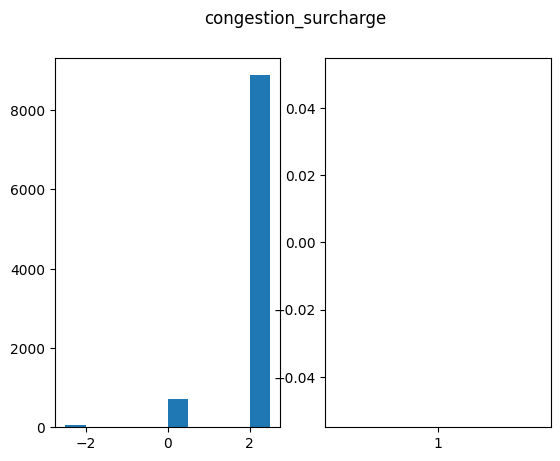

Mode= 2.5
Mean= 2.2923803591819785
Median= 2.5


Distribution of the variable airport_fee


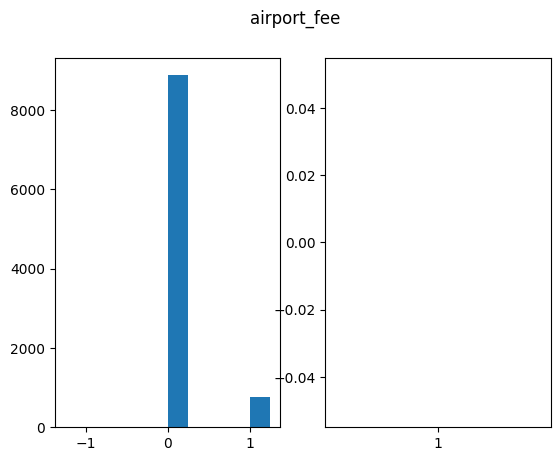

Mode= 0.0
Mean= 0.09719194435793627
Median= 0.0


Distribution of the variable duration


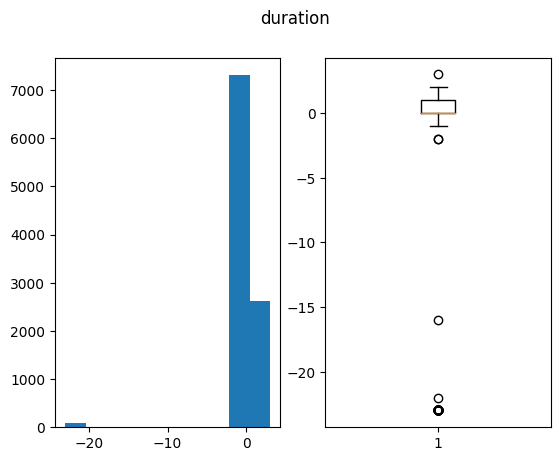

Mode= 0
Mean= 0.0813
Median= 0.0




In [10]:
import statistics as stat

numerics = df_subset.drop("store_and_fwd_flag", axis= 1)


for elem in numerics.columns:
  print(f"Distribution of the variable {elem}")
  
  # Graficos de histograma y cajas
  fig, axes = plt.subplots(nrows=1, ncols=2)
  fig.suptitle(elem)
  axes[0].hist(numerics[elem])
  axes[1].boxplot(x=elem, data=numerics)
  plt.show()

  # Moda, media y mediana
  mode=stat.mode(numerics[elem])
  print (f"Mode= {mode}")
  print (f"Mean= {numerics[elem].mean()}")
  print (f"Median= {numerics[elem].median()}", end = "\n\n\n")

Knowing that the dataset contains variables that are not informative, we will drop the variables "Vendor ID" (just codifies the company on wich the cellphone works), "store_and_fwd_flag" (not relevant information) and "payment_type" (just code the customers prefered payment type and there is an overrepresentaion of cash).

In [13]:
df_subset = df_subset.drop(["VendorID", "store_and_fwd_flag", "payment_type"], axis=1)

### Null values drop

In [22]:
df_subset = df_subset.dropna()

### Outliers detection

In [18]:
def outliers_detection (variable):
  fig, axes = plt.subplots(nrows=1, ncols=2)
  fig.suptitle(variable)
  axes[0].hist(df_subset[variable])
  axes[1].boxplot(x=variable, data=df)
  plt.show()
  percentile_25 = np.percentile(df_subset[variable], 25)
  percentile_50 = np.percentile(df_subset[variable], 50)
  percentile_75 = np.percentile(df_subset[variable], 75)
  print(f"mín = {df_subset[variable].min()}")
  print(f"Percentile 0.25 = {percentile_25}")
  print(f"Percentile 0.50 = {percentile_25}")
  print(f"Percentile 0.75 = {percentile_75}")
  print(f"max = {df_subset[variable].max()}")

In [75]:
def clean_outliers (variable):
  iqr = np.percentile(df_subset[variable], 75)- np.percentile(df_subset[variable], 25)
  max = np.percentile(df_subset[variable], 75) + 1.5 *iqr
  min = np.percentile(df_subset[variable], 25)- 1.5*iqr
  filtered = df_subset[(df_subset[variable] <= max) & (df_subset[variable] >= min)]
  return filtered

## Chequear si hay mas de un dropout zone por viaje (viajes compartidos). Googlear 

In [76]:
filtered_df = clean_outliers('passenger_count')

In [15]:
df_subset.columns

Index(['passenger_count', 'trip_distance', 'RatecodeID', 'PULocationID',
       'DOLocationID', 'fare_amount', 'extra', 'mta_tax', 'tip_amount',
       'tolls_amount', 'improvement_surcharge', 'total_amount',
       'congestion_surcharge', 'airport_fee', 'duration'],
      dtype='object')

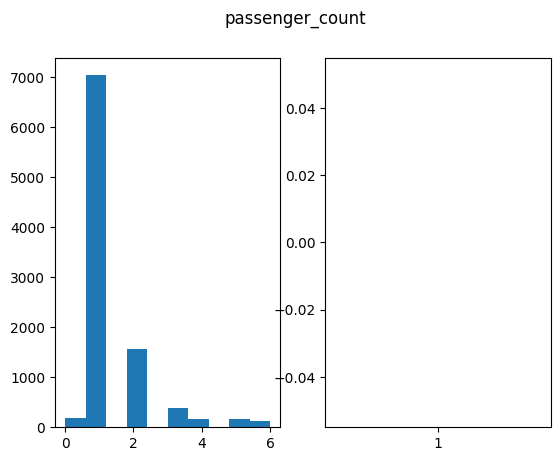

mín = 0.0
Percentile 0.25 = 1.0
Percentile 0.50 = 1.0
Percentile 0.75 = 2.0
max = 6.0


In [51]:
outliers_detection('passenger_count')

In [ ]:
filtered_df = clean_outliers('passenger_count')